In [1]:
import argparse
import os
import pathlib
import shutil
import sys

import numpy as np
import tqdm
from arg_parsing_utils import check_for_missing_args, parse_args
from file_reading import read_zstack_image
from notebook_init_utils import bandicoot_check, init_notebook

root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)

from file_checking import check_number_of_files
from file_reading import find_files_available, read_in_channels
from read_in_channel_mapping import retrieve_channel_mapping

channel_dict = retrieve_channel_mapping(f"{root_dir}/data/channel_mapping.toml")

In [17]:
if not in_notebook:
    args = parse_args()
    well_fov = args["well_fov"]
    patient = args["patient"]
    input_subparent_name = args["input_subparent_name"]
    mask_subparent_name = args["mask_subparent_name"]
    check_for_missing_args(
        well_fov=well_fov,
        patient=patient,
        input_subparent_name=input_subparent_name,
        mask_subparent_name=mask_subparent_name,
    )
else:
    patient = "NF0014_T1"
    well_fov = "D8-2"
    input_subparent_name = "zstack_images"
    mask_subparent_name = "segmentation_masks"

In [18]:
# set path to the processed data dir
segmentation_data_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{mask_subparent_name}/{well_fov}"
).resolve(strict=True)
zstack_dir = pathlib.Path(
    f"{image_base_dir}/data/{patient}/{input_subparent_name}/{well_fov}"
).resolve(strict=True)

In [19]:
image_dict = read_in_channels(
    find_files_available(zstack_dir),
    channel_dict=channel_dict,
    channels_to_read=["AGP"],
)

mask_dict = read_in_channels(
    find_files_available(segmentation_data_dir),
    channel_dict=channel_dict,
    channels_to_read=["Cell"],
)


cell_mask = mask_dict["Cell"]
cyto2 = image_dict["AGP"]

In [20]:
# remove all segmentations touching the border within 10 pixels


def clean_border_objects(segmentation, border_width=20):
    cleaned_seg = segmentation.copy()
    max_z, max_y, max_x = segmentation.shape
    border_labels = set()
    # check x borders
    border_labels.update(np.unique(segmentation[:, :, max_x - border_width :]))
    border_labels.update(np.unique(segmentation[:, :, :border_width]))
    # check y borders
    border_labels.update(np.unique(segmentation[:, :border_width, :]))
    border_labels.update(np.unique(segmentation[:, -border_width:, :]))
    # remove these labels
    for label in border_labels:
        if label == 0:
            continue
        cleaned_seg[segmentation == label] = 0
    return cleaned_seg


cell_mask_cleaned = clean_border_objects(cell_mask, border_width=25)
# remove small objects
from skimage import measure, morphology

cell_mask_cleaned = morphology.remove_small_objects(cell_mask_cleaned, min_size=250)

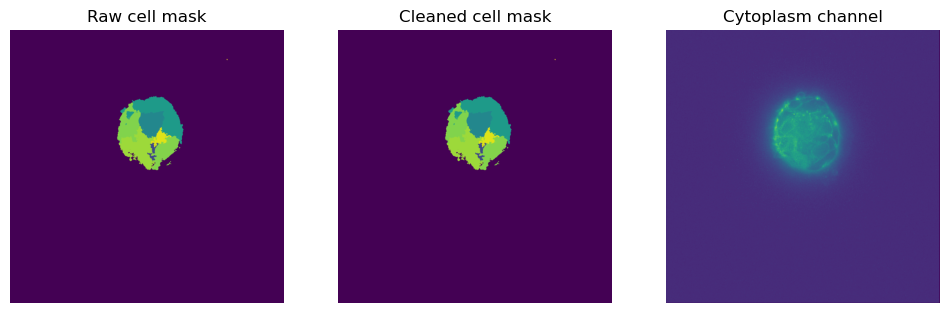

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Raw cell mask")
plt.imshow(cell_mask[cell_mask.shape[0] // 2])
plt.axis("off")
plt.subplot(1, 3, 2)
plt.title("Cleaned cell mask")
plt.axis("off")
plt.imshow(cell_mask_cleaned[cell_mask_cleaned.shape[0] // 2])
plt.subplot(1, 3, 3)
plt.title("Cytoplasm channel")
plt.axis("off")
plt.imshow(cyto2[cyto2.shape[0] // 2])
plt.show()